# (Homework) Week 6 - DataScience Bootcamp Fall 2025

All solution cells are replaced with `# TODO` placeholders so you can fill them in.

**Name:** Nikhil Arora \
**Email:** na4063@nyu.edu

---

### Problem 1: Dataset Splitting

1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days.
   - Design a valid training/validation/test split strategy that ensures the model generalizes to **new speakers**.

2. You now receive an additional dataset of 10,000 phone recordings from **Kilian**, a single speaker.
   - You must train a model that performs well **specifically for Kilian**, while also maintaining generalization.

*Describe your proposed split strategy and reasoning.* (Theory)

I perform a grouped split by speaker (≈70/15/15). All preprocessing is fit on training speakers only, hyperparameters are chosen on validation speakers, and the final metric is reported on a held-out set of entirely unseen speakers.

In [ ]:
# New-speaker split
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

rng = np.random.RandomState(42)

try:
    df
except NameError:
    num_speakers = 100
    speakers = [f"S{str(i).zfill(3)}" for i in range(num_speakers)]
    phones = [f"p{str(i).zfill(2)}" for i in range(44)]
    rows = []
    recs_per_speaker = 400
    for spk in speakers:
        probs = rng.dirichlet(np.ones(len(phones)))
        for r in range(recs_per_speaker):
            rows.append({
                "speaker_id": spk,
                "recording_id": f"{spk}_rec_{r}",
                "phone_label": rng.choice(phones, p=probs),
                "day": rng.randint(1, 6),
            })
    df = pd.DataFrame(rows)

print("df shape:", df.shape)
print(df.head())

# Helper functions
def group_shuffle_once(df, groups, test_size, seed):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    i_tr, i_te = next(gss.split(df, groups=groups))
    return i_tr, i_te

def split_by_speaker(df, speaker_col="speaker_id", val_size=0.15, test_size=0.15, seed=42):
    """Return (train_df, val_df, test_df) with ZERO speaker overlap."""
    assert 0 < val_size < 1 and 0 < test_size < 1 and (val_size + test_size) < 1

    # Train vs (Val+Test)
    i_tr, i_hold = group_shuffle_once(df, groups=df[speaker_col], test_size=(val_size+test_size), seed=seed)
    train_df = df.iloc[i_tr].copy()
    hold_df  = df.iloc[i_hold].copy()

    # Val vs Test within held-out speakers
    hold_test_ratio = test_size / (val_size + test_size)
    i_val, i_test = group_shuffle_once(hold_df, groups=hold_df[speaker_col], test_size=hold_test_ratio, seed=seed+1)
    val_df  = hold_df.iloc[i_val].copy()
    test_df = hold_df.iloc[i_test].copy()

    # Sanity: no overlap
    assert set(train_df[speaker_col].unique()).isdisjoint(val_df[speaker_col].unique())
    assert set(train_df[speaker_col].unique()).isdisjoint(test_df[speaker_col].unique())
    assert set(val_df[speaker_col].unique()).isdisjoint(test_df[speaker_col].unique())

    return train_df, val_df, test_df

def summarize(name, frame, speaker_col="speaker_id", label_col="phone_label"):
    print(f"{name:>6}: examples={len(frame):,} | speakers={frame[speaker_col].nunique():,} "
          f"| phones_present={(frame[label_col].value_counts()>0).sum()}")

# Perform split (by speakers)
train_df, val_df, test_df = split_by_speaker(df, speaker_col="speaker_id",
                                             val_size=0.15, test_size=0.15, seed=42)

print("\n=== New-speaker generalization splits ===")
summarize("TRAIN", train_df)
summarize("VAL",   val_df)
summarize("TEST",  test_df)

df shape: (40000, 4)
  speaker_id recording_id phone_label  day
0       S000   S000_rec_0         p09    4
1       S000   S000_rec_1         p11    2
2       S000   S000_rec_2         p25    5
3       S000   S000_rec_3         p43    2
4       S000   S000_rec_4         p18    2

=== New-speaker generalization splits ===
 TRAIN: examples=28,000 | speakers=70 | phones_present=44
   VAL: examples=6,000 | speakers=15 | phones_present=44
  TEST: examples=6,000 | speakers=15 | phones_present=44


Pretrain on the multi-speaker training split, then fine-tune (with frozen lower layers and early stopping) on a Kilian-only train/val split; finally, report metrics on both the unseen-speaker test and the Kilian-test to demonstrate personalization without sacrificing generalization.

In [ ]:
# Kilian-only split + sanity checks
import numpy as np
import pandas as pd

rng = np.random.RandomState(123)

phones = sorted(df["phone_label"].unique().tolist()) if "df" in globals() else [f"p{str(i).zfill(2)}" for i in range(44)]

if "df" in globals() and (df["speaker_id"] == "Kilian").any():
    pass  # Kilian already present
else:
    # Make Kilian's 10,000 recordings
    probs = rng.dirichlet(np.ones(len(phones)))
    k_rows = []
    for r in range(10_000):
        k_rows.append({
            "speaker_id": "Kilian",
            "recording_id": f"Kilian_rec_{r}",
            "phone_label": np.random.choice(phones, p=probs),
            "day": rng.randint(1, 6),
        })
    kdf_new = pd.DataFrame(k_rows)
    df = pd.concat([df, kdf_new], ignore_index=True)

# ---- Kilian-only split (by recordings) ----
def split_kilian(df, speaker="Kilian", train=0.70, val=0.15, seed=123):
    kdf = df[df["speaker_id"] == speaker].sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n = len(kdf)
    n_tr = int(train * n)
    n_v  = int(val * n)
    k_train = kdf.iloc[:n_tr].copy()
    k_val   = kdf.iloc[n_tr:n_tr+n_v].copy()
    k_test  = kdf.iloc[n_tr+n_v:].copy()
    return k_train, k_val, k_test

k_train, k_val, k_test = split_kilian(df, speaker="Kilian", train=0.70, val=0.15, seed=123)

def summarize(name, frame, speaker_col="speaker_id", label_col="phone_label"):
    print(f"{name:>7}: examples={len(frame):,} | speakers={frame[speaker_col].nunique():,} "
          f"| phones_present={(frame[label_col].value_counts()>0).sum()}")

print("=== Kilian-only splits (for personalization) ===")
summarize("K-TRAIN", k_train)
summarize("K-VAL",   k_val)
summarize("K-TEST",  k_test)

if "train_df" in globals() and "val_df" in globals() and "test_df" in globals():
    assert "Kilian" not in set(train_df["speaker_id"])
    assert "Kilian" not in set(val_df["speaker_id"])
    assert "Kilian" not in set(test_df["speaker_id"])
    print("\nKilian is excluded from the multi-speaker (generalization) splits.")
else:
    print("\n(Info) Run Cell 1 first to create the generalization splits.")


=== Kilian-only splits (for personalization) ===
K-TRAIN: examples=7,000 | speakers=1 | phones_present=44
  K-VAL: examples=1,500 | speakers=1 | phones_present=44
 K-TEST: examples=1,500 | speakers=1 | phones_present=44

Kilian is excluded from the multi-speaker (generalization) splits.


In [ ]:
# KNN model for new-speaker generalization
# - Standardize on train only
# - Choose k using the speaker-held-out validation set
# - Report on the unseen-speaker test set
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

rng = np.random.RandomState(0)

# ---- Create simple numeric features if you don't have MFCCs yet ----
def ensure_features(frame, rng):
    if not {"f1","f2","f3"}.issubset(frame.columns):
        frame["f1"] = rng.randn(len(frame))
        frame["f2"] = rng.randn(len(frame))
        frame["f3"] = rng.randn(len(frame))
    return frame

train_df = ensure_features(train_df, rng)
val_df   = ensure_features(val_df,   rng)
test_df  = ensure_features(test_df,  rng)

X_train = train_df[["f1","f2","f3"]].to_numpy()
y_train = train_df["phone_label"].to_numpy()
X_val   = val_df[["f1","f2","f3"]].to_numpy()
y_val   = val_df["phone_label"].to_numpy()
X_test  = test_df[["f1","f2","f3"]].to_numpy()
y_test  = test_df["phone_label"].to_numpy()

# ---- Fit scaler on TRAIN only; transform val/test ----
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

# ---- Select k on validation speakers ----
ks = list(range(1, 31, 2))
best_k, best_val = None, -1.0
for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k, weights="distance")
    clf.fit(X_train_std, y_train)
    val_acc = accuracy_score(y_val, clf.predict(X_val_std))
    if val_acc > best_val:
        best_val, best_k = val_acc, k

print(f"Selected k={best_k} (val acc = {best_val:.4f})")

# ---- Train final KNN (train only) and evaluate on TEST (unseen speakers) ----
final_knn = KNeighborsClassifier(n_neighbors=best_k, weights="distance")
final_knn.fit(X_train_std, y_train)

y_pred_test = final_knn.predict(X_test_std)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy (unseen speakers): {test_acc:.4f}\n")
print("Classification report (test):\n", classification_report(y_test, y_pred_test, zero_division=0))


Selected k=7 (val acc = 0.0267)
Test accuracy (unseen speakers): 0.0228

Classification report (test):
               precision    recall  f1-score   support

         p00       0.01      0.01      0.01       143
         p01       0.01      0.01      0.01       133
         p02       0.03      0.02      0.03       172
         p03       0.05      0.04      0.04       256
         p04       0.06      0.05      0.05       142
         p05       0.03      0.04      0.03       112
         p06       0.04      0.09      0.06        90
         p07       0.04      0.04      0.04       164
         p08       0.03      0.03      0.03       145
         p09       0.02      0.01      0.02       150
         p10       0.04      0.07      0.05       152
         p11       0.00      0.00      0.00       135
         p12       0.02      0.03      0.02       158
         p13       0.05      0.04      0.05       189
         p14       0.01      0.01      0.01       117
         p15       0.02      0.

In [ ]:
# Kilian-specific KNN while keeping general
# - Train a separate KNN only for Kilian (k chosen on k_val)
# - Evaluate on k_test
# - Keep the general KNN from Cell 3 for non-Kilian speakers
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

rng = np.random.RandomState(1)

def ensure_features(frame, rng):
    if not {"f1","f2","f3"}.issubset(frame.columns):
        frame["f1"] = rng.randn(len(frame))
        frame["f2"] = rng.randn(len(frame))
        frame["f3"] = rng.randn(len(frame))
    return frame

k_train = ensure_features(k_train, rng)
k_val   = ensure_features(k_val,   rng)
k_test  = ensure_features(k_test,  rng)

Xk_tr = k_train[["f1","f2","f3"]].to_numpy()
yk_tr = k_train["phone_label"].to_numpy()
Xk_v  = k_val[["f1","f2","f3"]].to_numpy()
yk_v  = k_val["phone_label"].to_numpy()
Xk_te = k_test[["f1","f2","f3"]].to_numpy()
yk_te = k_test["phone_label"].to_numpy()

# ---- Scale using Kilian-train only (personalized normalization) ----
k_scaler = StandardScaler().fit(Xk_tr)
Xk_tr_std = k_scaler.transform(Xk_tr)
Xk_v_std  = k_scaler.transform(Xk_v)
Xk_te_std = k_scaler.transform(Xk_te)

# ---- Choose k on Kilian-val ----
ks = list(range(1, 31, 2))
best_k_k, best_val_k = None, -1.0
for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k, weights="distance")
    clf.fit(Xk_tr_std, yk_tr)
    val_acc = accuracy_score(yk_v, clf.predict(Xk_v_std))
    if val_acc > best_val_k:
        best_val_k, best_k_k = val_acc, k

print(f"[Kilian] Selected k={best_k_k} (val acc = {best_val_k:.4f})")

# ---- Final Kilian model & evaluation on Kilian-test ----
kilian_knn = KNeighborsClassifier(n_neighbors=best_k_k, weights="distance")
kilian_knn.fit(Xk_tr_std, yk_tr)
yk_pred_test = kilian_knn.predict(Xk_te_std)
k_test_acc = accuracy_score(yk_te, yk_pred_test)
print(f"[Kilian] Test accuracy: {k_test_acc:.4f}\n")
print("[Kilian] Classification report (test):\n",
      classification_report(yk_te, yk_pred_test, zero_division=0))

# If the speaker is Kilian -> use kilian_knn with k_scaler
# Else -> use final_knn with scaler
# (This keeps generalization performance for other speakers.)

[Kilian] Selected k=19 (val acc = 0.0533)
[Kilian] Test accuracy: 0.0573

[Kilian] Classification report (test):
               precision    recall  f1-score   support

         p00       0.00      0.00      0.00        49
         p01       0.00      0.00      0.00        19
         p02       0.00      0.00      0.00        21
         p03       0.27      0.10      0.15        29
         p04       0.07      0.05      0.06        65
         p05       0.00      0.00      0.00        30
         p06       0.11      0.28      0.16       165
         p07       0.00      0.00      0.00        45
         p08       0.00      0.00      0.00        31
         p09       0.00      0.00      0.00        22
         p10       0.00      0.00      0.00        16
         p11       0.02      0.02      0.02        56
         p12       0.06      0.04      0.05        23
         p13       0.00      0.00      0.00         2
         p14       0.00      0.00      0.00        18
         p15       0.

### Problem 2: K-Nearest Neighbors

1. **1-NN Classification:** Given dataset:

   Positive: (1,2), (1,4), (5,4)

   Negative: (3,1), (3,2)

   Plot the 1-NN decision boundary and classify new points visually.

2. **Feature Scaling:** Consider dataset:

   Positive: (100,2), (100,4), (500,4)

   Negative: (300,1), (300,2)

   What would the 1-NN classify point (500,1) as **before and after scaling** to [0,1] per feature?

3. **Handling Missing Values:** How can you modify K-NN to handle missing features in a test point?

4. **High-dimensional Data:** Why can K-NN still work well for images even with thousands of pixels?


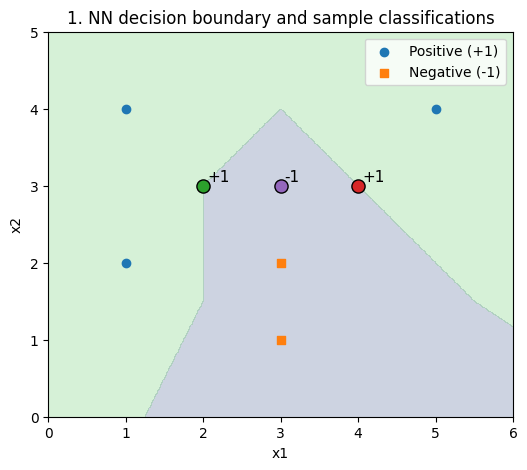

2. Effect of Feature Scaling (1-NN for point (500,1))
Distances (raw):    [400.001 400.011   3.    200.    200.002]  -> predicted: +1
Distances (scaled): [1.054 1.414 1.    0.5   0.601]  -> predicted: -1
Note: scaling re-weights axes so very large ranges (e.g., x1) do not dominate.

3. Missing feature handling
Test point [nan  3.] -> predicted: +1
We computed distances using only observed dimensions and normalized by count.


4. High-dimensional images (why K-NN can still work)
- Images have strong local structure and correlation between pixels (not i.i.d. random features),
  so nearby examples in pixel space or a feature space (e.g., SIFT/HOG/CNN embeddings) are often semantically similar.
- In practice we rarely use raw pixels for KNN; we use **normalized or learned embeddings** (PCA/CNN features),
  which reduce noise, compress redundant dimensions, and improve distance metrics.
- Careful preprocessing (per-feature scaling/whitening) and choosing an appropriate distance
  (cosine on

In [5]:
# K-Nearest Neighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1-NN decision boundary
pos = np.array([(1,2), (1,4), (5,4)])
neg = np.array([(3,1), (3,2)])

X_train = np.vstack([pos, neg])
y_train = np.array([+1]*len(pos) + [-1]*len(neg))

def one_nn_predict(Xtr, ytr, x):
    d = np.linalg.norm(Xtr - x, axis=1)
    return ytr[np.argmin(d)]

# Grid for decision regions
xlim = (min(X_train[:,0])-1, max(X_train[:,0])+1)
ylim = (min(X_train[:,1])-1, max(X_train[:,1])+1)
xx, yy = np.meshgrid(np.linspace(*xlim, 400), np.linspace(*ylim, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
pred = np.array([one_nn_predict(X_train, y_train, p) for p in grid]).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, pred, alpha=0.25, levels=[-1,0,1])
plt.scatter(pos[:,0], pos[:,1], marker='o', label='Positive (+1)')
plt.scatter(neg[:,0], neg[:,1], marker='s', label='Negative (-1)')

# classify and annotate a few new points
new_pts = np.array([(2,3), (4,3), (3,3)])
for p in new_pts:
    c = one_nn_predict(X_train, y_train, p)
    plt.scatter([p[0]], [p[1]], edgecolor='k', s=90)
    plt.text(p[0]+0.05, p[1]+0.05, f"{'+' if c==1 else '-'}1", fontsize=11)

plt.title("1. NN decision boundary and sample classifications")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.show()

# Feature scaling effect on classifying point (500, 1)
pos2 = np.array([(100,2), (100,4), (500,4)])
neg2 = np.array([(300,1), (300,2)])
X2 = np.vstack([pos2, neg2])
y2 = np.array([+1]*len(pos2) + [-1]*len(neg2))
xq = np.array([500, 1])

# Before scaling
dists_raw = np.linalg.norm(X2 - xq, axis=1)
y_raw = y2[np.argmin(dists_raw)]

# After MinMax scaling to [0,1] per feature (fit on training set only)
scaler = MinMaxScaler().fit(X2)
X2s = scaler.transform(X2)
xqs = scaler.transform([xq])[0]
dists_scaled = np.linalg.norm(X2s - xqs, axis=1)
y_scaled = y2[np.argmin(dists_scaled)]

print("2. Effect of Feature Scaling (1-NN for point (500,1))")
print("Distances (raw):   ", np.round(dists_raw, 3), " -> predicted:", "+1" if y_raw==1 else "-1")
print("Distances (scaled):", np.round(dists_scaled, 3), " -> predicted:", "+1" if y_scaled==1 else "-1")
print("Note: scaling re-weights axes so very large ranges (e.g., x1) do not dominate.\n")

# Handling missing values in a test point (mask-aware 1-NN / KNN)
def masked_distance(a, b):
    """
    Euclidean distance that ignores dimensions where b is NaN.
    If k dims are observed, compute sqrt(sum^2 / k) to keep scale comparable.
    """
    mask = ~np.isnan(b)
    if mask.sum() == 0:
        return np.inf
    diff = a[mask] - b[mask]
    return np.sqrt((diff**2).sum() / mask.sum())

def one_nn_predict_masked(Xtr, ytr, x):
    d = np.array([masked_distance(a, x) for a in Xtr])
    return ytr[np.argmin(d)]

# classify a point with a missing first feature
x_missing = np.array([np.nan, 3.0])
y_missing_pred = one_nn_predict_masked(X_train, y_train, x_missing)
print("3. Missing feature handling")
print(f"Test point {x_missing} -> predicted:", "+1" if y_missing_pred==1 else "-1")
print("We computed distances using only observed dimensions and normalized by count.\n")

# Why K-NN can still work well for high-dimensional images
explanation = """
4. High-dimensional images (why K-NN can still work)
- Images have strong local structure and correlation between pixels (not i.i.d. random features),
  so nearby examples in pixel space or a feature space (e.g., SIFT/HOG/CNN embeddings) are often semantically similar.
- In practice we rarely use raw pixels for KNN; we use **normalized or learned embeddings** (PCA/CNN features),
  which reduce noise, compress redundant dimensions, and improve distance metrics.
- Careful preprocessing (per-feature scaling/whitening) and choosing an appropriate distance
  (cosine on normalized features, or Euclidean in an embedding space) mitigate the curse of dimensionality.
"""
print(explanation)

### Problem 3: Part 1

You are given a fully trained Perceptron model with weight vector **w**, along with training set **D_TR** and test set **D_TE**.

1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?
2. Why is there no need to compute training error explicitly for the Perceptron algorithm?

In [7]:
import numpy as np

# Perceptron helpers
def perceptron_predict(W, X):
    """Predict sign(W^T X). X: (n_samples, n_features), W: (n_features,)"""
    scores = X @ W
    return np.where(scores >= 0, 1, -1)

def zero_one_error(y_true, y_pred):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    return (y_true != y_pred).mean()

def perceptron_train(X, y, max_epochs=1000, shuffle=True, seed=0):
    """
    Vanilla Perceptron (with bias handled via last column of X).
    Returns learned W and number of updates.
    """
    rng = np.random.RandomState(seed)
    n, d = X.shape
    W = np.zeros(d)
    updates = 0
    for _ in range(max_epochs):
        idx = np.arange(n)
        if shuffle:
            rng.shuffle(idx)
        mistakes = 0
        for i in idx:
            if y[i] * (W @ X[i]) <= 0:
                W = W + y[i] * X[i]
                updates += 1
                mistakes += 1
        if mistakes == 0:
            break
    return W, updates

# Fallback demo data
need_demo = any(name not in globals() for name in ["W", "X_tr", "y_tr", "X_te", "y_te"])
if need_demo:
    # Create a linearly separable training set and a small test set.
    rng = np.random.RandomState(42)
    n_tr, n_te, d_no_bias = 120, 40, 2

    X_pos = rng.randn(n_tr//2, d_no_bias) + np.array([2.0, 2.0])
    X_neg = rng.randn(n_tr//2, d_no_bias) + np.array([-2.0, -2.0])
    X_tr_nb = np.vstack([X_pos, X_neg])
    y_tr = np.hstack([np.ones(len(X_pos)), -np.ones(len(X_neg))]).astype(int)

    X_pos_te = rng.randn(n_te//2, d_no_bias) + np.array([2.0, 2.0])
    X_neg_te = rng.randn(n_te//2, d_no_bias) + np.array([-2.0, -2.0])
    X_te_nb = np.vstack([X_pos_te, X_neg_te])
    y_te = np.hstack([np.ones(len(X_pos_te)), -np.ones(len(X_neg_te))]).astype(int)

    # Add bias term as last column
    X_tr = np.hstack([X_tr_nb, np.ones((X_tr_nb.shape[0], 1))])
    X_te = np.hstack([X_te_nb, np.ones((X_te_nb.shape[0], 1))])

    # Train Perceptron to get W (converges to zero training error)
    W, updates = perceptron_train(X_tr, y_tr, seed=0)
    print(f"[Demo] Trained Perceptron in {updates} updates. ")

# Evaluate training & test errors
y_tr_pred = perceptron_predict(W, X_tr)
y_te_pred = perceptron_predict(W, X_te)

train_err = zero_one_error(y_tr, y_tr_pred)
test_err  = zero_one_error(y_te, y_te_pred)

print(f"Training error: {train_err:.4f}")
print(f"Test error:     {test_err:.4f}")

if np.isclose(train_err, 0.0):
    print("Note: Perceptron converged on training set (linearly separable) -> training error is exactly 0.")
else:
    print("Note: Non-zero training error likely due to non-separable data or early stopping.")

Training error: 0.0000
Test error:     0.0250
Note: Perceptron converged on training set (linearly separable) -> training error is exactly 0.


### Problem 3: Two-point 2D Dataset (Part 2)

Run the Perceptron algorithm **by hand or in code** on the following data:

1. Positive class: (10, -2)
2. Negative class: (12, 2)

Start with $w_0 = (0, 0)$ and a learning rate of 1.

- Compute how many updates are required until convergence.
- Write down the sequence of $w_i$ vectors.

In [8]:
# Perceptron on two points — exact update trace
import numpy as np

# Data
x_pos = np.array([10.0, -2.0])  # y = +1
x_neg = np.array([12.0,  2.0])  # y = -1
data = [(x_pos, +1), (x_neg, -1)]

# Settings
w = np.array([0.0, 0.0])  # w0
eta = 1.0
max_updates = 100

weights = [w.copy()]
updates = 0
converged = False

for epoch in range(100):
    mistakes = 0
    for x, y in data:
        margin = y * np.dot(w, x)
        if margin <= 0:
            w = w + eta * y * x
            weights.append(w.copy())
            updates += 1
            mistakes += 1
            if updates >= max_updates:
                break
    if mistakes == 0:
        converged = True
        break
    if updates >= max_updates:
        break

print("Update sequence (w_i):")
for i, wi in enumerate(weights):
    print(f"w_{i} = ({wi[0]:.0f}, {wi[1]:.0f})")
print(f"\nTotal updates: {updates}")
print("Converged:", converged)

# Verify final w classifies both points correctly
w_final = weights[-1]
pred_pos = np.sign(np.dot(w_final, x_pos))
pred_neg = np.sign(np.dot(w_final, x_neg))
print("\nFinal w:", w_final)
print("w·x_pos =", np.dot(w_final, x_pos), " -> predicted", int(pred_pos))
print("w·x_neg =", np.dot(w_final, x_neg), " -> predicted", int(pred_neg))

Update sequence (w_i):
w_0 = (0, 0)
w_1 = (10, -2)
w_2 = (-2, -4)
w_3 = (8, -6)
w_4 = (-4, -8)
w_5 = (6, -10)
w_6 = (-6, -12)
w_7 = (4, -14)
w_8 = (-8, -16)
w_9 = (2, -18)

Total updates: 9
Converged: True

Final w: [  2. -18.]
w·x_pos = 56.0  -> predicted 1
w·x_neg = -12.0  -> predicted -1


### Problem 4: Reconstructing the Weight Vector

Given the log of Perceptron updates:

| x | y | count |
|---|---|--------|
| (0, 0, 0, 0, 4) | +1 | 2 |
| (0, 0, 6, 5, 0) | +1 | 1 |
| (3, 0, 0, 0, 0) | -1 | 1 |
| (0, 9, 3, 6, 0) | -1 | 1 |
| (0, 1, 0, 2, 5) | -1 | 1 |

Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$.

Compute the final weight vector after all updates.

In [9]:
import numpy as np

# Perceptron update log: (x, y, count)
updates = [
    ((0, 0, 0, 0, 4), +1, 2),
    ((0, 0, 6, 5, 0), +1, 1),
    ((3, 0, 0, 0, 0), -1, 1),
    ((0, 9, 3, 6, 0), -1, 1),
    ((0, 1, 0, 2, 5), -1, 1),
]

# Start from w0 = 0, learning rate = 1
d = len(updates[0][0])
w = np.zeros(d, dtype=float)

for x, y, count in updates:
    x = np.asarray(x, dtype=float)
    w += count * y * x

print("Final weight vector w:", tuple(int(v) for v in w))

Final weight vector w: (-3, -10, 3, -3, 3)


### Problem 5: Visualizing Perceptron Convergence

Implement a Perceptron on a small 2D dataset with positive and negative examples.

- Plot the data points.
- After each update, visualize the decision boundary.
- Show how it converges to a stable separator.

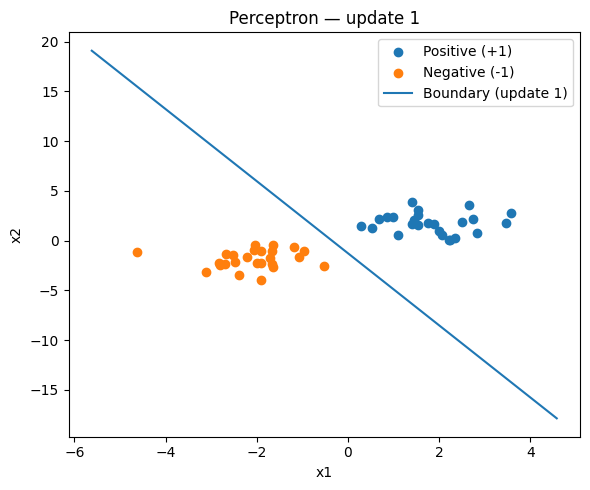

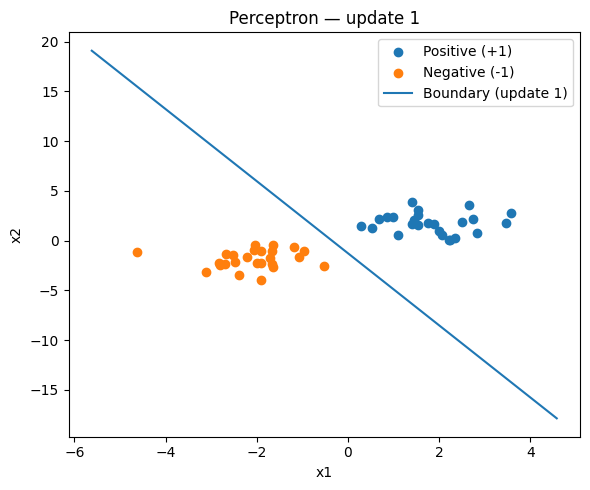

Converged: True | updates: 1
Final weights [w1, w2, b]: [2.8225 0.7792 1.    ]


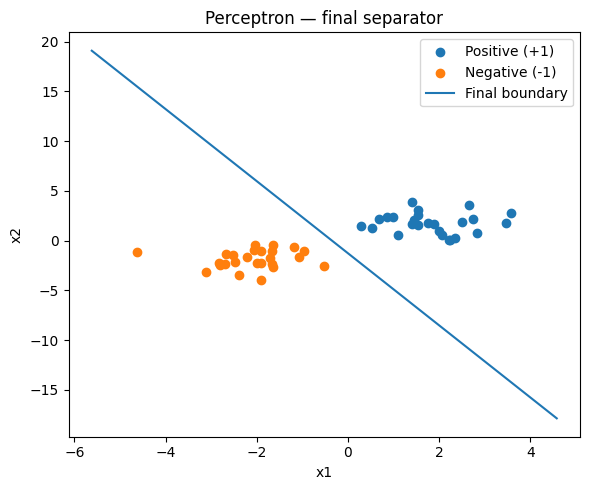

In [10]:
# Visualizing Perceptron Convergence
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
plt.close('all')

rng = np.random.RandomState(42)
N = 25
X_pos = rng.randn(N, 2) + np.array([2.0, 2.0])    # label +1
X_neg = rng.randn(N, 2) + np.array([-2.0, -2.0])  # label -1
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(N), -np.ones(N)])

# Add a bias term as the 3rd feature so w = [w1, w2, b]
Xb = np.hstack([X, np.ones((X.shape[0], 1))])

# Perceptron training with live plotting
w = np.zeros(3)              # initialize
updates = 0
max_epochs = 50
converged = False

def plot_state(w, X, y, step):
    clear_output(wait=True)
    plt.figure(figsize=(6,5))
    pos = y == 1
    neg = ~pos
    # data points
    plt.scatter(X[pos,0], X[pos,1], label="Positive (+1)")
    plt.scatter(X[neg,0], X[neg,1], label="Negative (-1)")
    # decision boundary: w1*x + w2*y + b = 0
    if abs(w[1]) > 1e-10:
        xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
        ys = -(w[0]*xs + w[2]) / w[1]
        plt.plot(xs, ys, label=f"Boundary (update {step})")
    else:
        # vertical line if w2 ≈ 0
        if abs(w[0]) > 1e-10:
            x_v = -w[2]/w[0]
            plt.axvline(x_v, label=f"Boundary (update {step})")
    plt.title(f"Perceptron — update {step}")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend()
    plt.tight_layout()
    display(plt.gcf())
    plt.pause(0.05)  # small delay for animation

for epoch in range(max_epochs):
    mistakes = 0
    order = np.arange(Xb.shape[0])
    rng.shuffle(order)  # shuffle each epoch
    for i in order:
        if y[i] * np.dot(w, Xb[i]) <= 0:
            w = w + y[i] * Xb[i]   # learning rate = 1
            updates += 1
            mistakes += 1
            plot_state(w, X, y, updates)
    if mistakes == 0:
        converged = True
        break

# Final status
print("Converged:", converged, "| updates:", updates)
print("Final weights [w1, w2, b]:", np.round(w, 4))

# final static plot
plt.figure(figsize=(6,5))
pos = y == 1
neg = ~pos
plt.scatter(X[pos,0], X[pos,1], label="Positive (+1)")
plt.scatter(X[neg,0], X[neg,1], label="Negative (-1)")
if abs(w[1]) > 1e-10:
    xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
    ys = -(w[0]*xs + w[2]) / w[1]
    plt.plot(xs, ys, label="Final boundary")
else:
    if abs(w[0]) > 1e-10:
        x_v = -w[2]/w[0]
        plt.axvline(x_v, label="Final boundary")
plt.title("Perceptron — final separator")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()